In [44]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics

import matplotlib.pyplot as plt

# Training RandomForests classifier

In [3]:
#Train data
trainCleaned = "dataset/two-sigma-connect-rental-listing-inquiries/trainTextExtract.json.zip"
trainData = pd.read_json(trainCleaned, convert_dates=['created'])

#Test data
testDataDir = "dataset/two-sigma-connect-rental-listing-inquiries/testTextExtract.json.zip"
testData = pd.read_json(testDataDir, convert_dates=['created'])

trainData.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'interest_level', 'latitude',
       'listing_id', 'longitude', 'manager_id', 'photos', 'price',
       'street_address', 'grayscale_hist', 'avg_pixel_values', 'num_photos',
       'desc_word_count', 'desc_char_count', 'desc_avg_word_length',
       'desc_special_char_count', 'desc_num_count', 'desc_upper_count',
       'num_features', 'year', 'month', 'day'],
      dtype='object')

## Features Selection

In [6]:
features_list = ['bathrooms', 'bedrooms', 'price', 'year', 'month', 'day', 'desc_word_count', 'desc_avg_word_length', 'num_features', 'latitude', 'longitude']
X = trainData[features_list]
X_test = testData[features_list]
X.head(5)

,bathrooms,bedrooms,price,year,month,day,desc_word_count,desc_avg_word_length,num_features,latitude,longitude
0,2.0,3,3050,2016,6,24,183,6.044199,8,40.6678,-73.9398
1,2.0,3,3100,2016,4,29,44,7.477273,0,40.6678,-73.9398
2,1.0,1,2850,2016,6,17,32,6.225806,3,40.7287,-73.9810
3,1.0,3,4200,2016,6,8,62,5.393443,3,40.7287,-73.9810
4,1.0,1,2850,2016,6,11,134,4.684211,3,40.7287,-73.9810


## Label Encoding

In [9]:
le=LabelEncoder()
target = trainData[['interest_level']]
y = le.fit_transform(target['interest_level'])
y

array([1, 1, 1, ..., 2, 2, 0])

## Buidling RandomForests model

### Original (using log loss metrics)
Note: The smaller the log loss, the better. <br/>
References: https://ggbaker.ca/data-science/content/ml-classif.html

In [32]:
model = RandomForestClassifier(n_estimators=100, max_depth=3, min_samples_leaf=10)
acc_scores = []
kf = StratifiedKFold(n_splits=5)
for train_index, val_index in kf.split(X, y):
    train_X, val_X = X.iloc[train_index,:], X.iloc[val_index,:]
    train_y, val_y = y[train_index], y[val_index]
    model.fit(train_X, train_y)
    val_y_pred = model.predict_proba(val_X)
    score = metrics.log_loss(val_y, val_y_pred)
    acc_scores.append(score)
    
np.mean(acc_scores)

0.7744704796744744

In [33]:
preds = model.predict_proba(X_test)
out_df = pd.DataFrame(preds)
out_df.columns = le.classes_
out_df["listing_id"] = testData.listing_id.values
out_df.to_csv("RandomForests-1.csv", index=False)
out_df

#evaluation from Kaggle: 0.74

,high,low,medium,listing_id
0,0.064418,0.691457,0.244125,7142618
1,0.079406,0.665912,0.254683,7210040
2,0.086416,0.667920,0.245664,7174566
3,0.077253,0.675816,0.246931,7191391
4,0.061571,0.691229,0.247200,7171695
...,...,...,...,...
74654,0.165330,0.538639,0.296031,6928108
74655,0.076588,0.647832,0.275581,6906674
74656,0.087632,0.660115,0.252253,6897967
74657,0.072530,0.678320,0.249150,6842183


### Detecting Overfitting
Overfitting tends to occur when <b>max_features</b> and/or <b>max_depths</b> increases.

[]

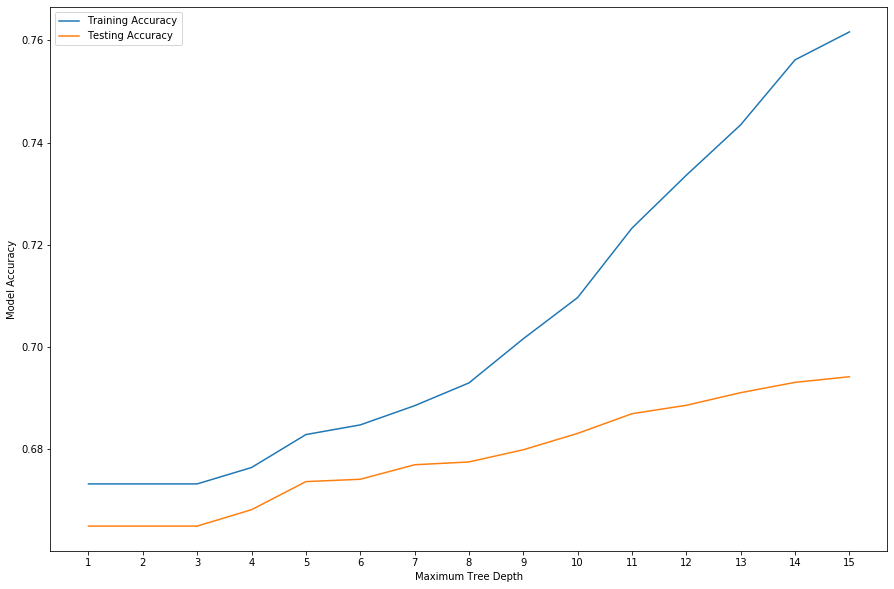

In [50]:
max_depth_list = np.linspace(1, 15, num=15)

train_accuracy = []
test_accuracy = []

X_train, X_test, y_train, y_test = train_test_split(X, y)

for d in max_depth_list:
    model = RandomForestClassifier(n_estimators=100, max_depth=int(d), min_samples_leaf=10) 
    model.fit(X_train,y_train)
    train_accuracy.append(model.score(X_train, y_train))
    test_accuracy.append(model.score(X_test, y_test))

x = np.arange(len(max_depth_list)) + 1
plt.figure(figsize=(15,10))
plt.xticks(x)
plt.plot(x, train_accuracy, label='Training Accuracy')
plt.plot(x, test_accuracy, label='Testing Accuracy')
plt.xlabel('Maximum Tree Depth')
plt.ylabel('Model Accuracy')
plt.legend()
plt.plot()

### Parameters Tuning
Reference: https://scikit-learn.org/stable/modules/ensemble.html#random-forest-parameters

In [40]:
model = RandomForestClassifier(n_estimators=100, max_depth=None, max_features=None, min_samples_leaf=10, min_samples_split=2)

acc_scores = []
kf = StratifiedKFold(n_splits=5)

for train_index, val_index in kf.split(X, y):
    train_X, val_X = X.iloc[train_index,:], X.iloc[val_index,:]
    train_y, val_y = y[train_index], y[val_index]
    model.fit(train_X, train_y)
    val_y_pred = model.predict_proba(val_X)
    score = metrics.log_loss(val_y, val_y_pred)
    acc_scores.append(score)
    
np.mean(acc_scores)

0.6973606521177252

In [38]:
preds = model.predict_proba(X_test)
out_df = pd.DataFrame(preds)
out_df.columns = le.classes_
out_df["listing_id"] = testData.listing_id.values
out_df.to_csv("RandomForests-2.csv", index=False)
out_df

#evaluation from Kaggle: 0.64 (improved)

,high,low,medium,listing_id
0,0.089101,0.636879,0.274019,7142618
1,0.265800,0.355443,0.378758,7210040
2,0.097313,0.634431,0.268256,7174566
3,0.272991,0.368352,0.358656,7191391
4,0.015431,0.895154,0.089414,7171695
...,...,...,...,...
74654,0.171891,0.489700,0.338409,6928108
74655,0.039710,0.720032,0.240258,6906674
74656,0.049098,0.792188,0.158714,6897967
74657,0.001678,0.956046,0.042275,6842183


### Accuracy Score

In [52]:
model = RandomForestClassifier(n_estimators=100, max_depth=None, max_features=None, min_samples_leaf=10, min_samples_split=2)

acc_scores = []
kf = StratifiedKFold(n_splits=5)

for train_index, val_index in kf.split(X, y):
    train_X, val_X = X.iloc[train_index,:], X.iloc[val_index,:]
    train_y, val_y = y[train_index], y[val_index]
    model.fit(train_X, train_y)
    val_y_pred = model.predict(val_X)
    score = metrics.accuracy_score(val_y, val_y_pred)
    acc_scores.append(score)
    
np.mean(acc_scores)

0.6828060541581056